# Elo for tennisrungs

## Crawl tennisrungs.com and scrape all info

In [42]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

LEAGUE_ID = "singles-3.0-3.5/143889747"


def parse_table(table):
    '''Parse table from scraped html.'''
    data = []
    for row in table.find_all('tr'):
        row_data = []
        for cell in row.find_all('td'):
            row_data.append(cell.text.strip())
            if cell.a is not None:
                row_data.append(cell.a['href'])
        data.append(row_data)
    return data[1:]
url_base = "https://app.tennisrungs.com"
url = f"{url_base}/atc/tennis-ladders/{LEAGUE_ID}"
req = requests.get(url)

soup = BeautifulSoup(req.text, "html.parser")
table = soup.find('table', {'id': 'ladderrankings'})
data = parse_table(table)
df_player = pd.DataFrame([(x[1], x[2], x[6]) for x in data])
df_player.columns = ['name', 'link', 'points']
df_player['player_id'] = df_player['link'].apply(lambda x: x.split('teamId=')[-1])
df_player.head()

,name,link,points,player_id
0,Stefano Cosentino,/Public/PlayerMatches/?teamId=144232167,115.00,144232167
1,Abhimanyu Yadav,/Public/PlayerMatches/?teamId=144264147,113.00,144264147
2,Shreyas Seshadri,/Public/PlayerMatches/?teamId=144264139,113.00,144264139
3,Pablo Caballero,/Public/PlayerMatches/?teamId=144367225,112.00,144367225
4,Devank Agarwal,/Public/PlayerMatches/?teamId=144569465,110.00,144569465


In [50]:
def calc_ratio_win(s, add_tb=False):
    '''Needs to be improved. Extract winning stats.'''
    if 'Forfeit' in s:
        # Ignore forfeit
        return 0.
    groups = [g.strip() for g in s.split(',')]
    num, den = 0, 0
    for g in groups[:2]:
        a, b = g[:3].split('-')
        num += int(a)
        den += int(a) + int(b)
    if add_tb and len(groups)==3:
        if groups[2][0]=='(':
            g, d = groups[2][1:-1], 4
        else:
            g, d = groups[2], 1
        a, b = g.split('-')
        # Roughly equate 1 TB won to 2.5 games
        num += 2.5
        den += 2.5
    return num/den

##################
# Create history by crawling all pages and logging results (will be deduplicated later)
results = []
for idx, row in df_player.iterrows():
    req = requests.get(f"{url_base}{row['link']}")
    soup = BeautifulSoup(req.text, "html.parser")
    table = soup.find('table', {'id': 'challenges'})
    if table is not None:
        res_ = parse_table(table)
        res_ = [[row['player_id'], row['name']] + r for r in res_]
        results.append(res_)

##################
# Cleanup the logs
df = pd.DataFrame([y for x in results for y in x])
df.columns = ['player_a_id', 'player_a',  'date', 'player_b', 'link', 'res', 'score']
# Add players that dropped fromt the challenge:
df['player_b_id'] = df['link'].apply(lambda x: x.split('teamId=')[-1])
for _, row in df.iterrows():
    if row['player_b_id'] not in df_player['player_id'].values:
        print(f'\tINFO: Adding dropped-player "{row["player_b"]}" to list.')
        df_player.loc[len(df_player.index)] = [row['player_b'], row['link'], None, row['player_b_id']] 
df['player_b'] = df['player_b_id'].apply(lambda x: df_player[df_player['player_id']==x].iloc[0]['name'])
# Add useful fields:
df['winner'] = df['res'].apply(lambda x: 'a' if x=='W' else 'b')
df['loser'] = df['res'].apply(lambda x: 'b' if x=='W' else 'a')
df['winner_name'] = df.apply(lambda x: x[f'player_{x["winner"]}'], axis=1)
# Create winning stats, maybe useful in the future:
df['ratio_win'] = df['score'].apply(lambda x: calc_ratio_win(x))
df['ratio_win'] = df.apply(lambda x: x['ratio_win'] if x['res']=='W' else 1-x['ratio_win'], axis=1)
df['ratio_win_tb'] = df['score'].apply(lambda x: calc_ratio_win(x, add_tb=True))
df['ratio_win_tb'] = df.apply(lambda x: x['ratio_win_tb'] if x['res']=='W' else 1-x['ratio_win_tb'], axis=1)
# Unique identidifer for a match:
df['match_uid'] = df.apply(lambda d: f"{d['date'].replace('/', '')}_{'_'.join(sorted(d[['player_a_id', 'player_b_id']]))}", axis=1)
# Sort chronologically:
df['date'] = pd.to_datetime(df['date'])
df['ts'] = df['date'].apply(lambda x: pd.Timestamp(x).timestamp())
df['week_nr'] = df['date'].dt.isocalendar().week
df = df.sort_values('ts').reset_index(drop=True)
df = df[['date', 'player_a', 'player_a_id', 'player_b', 'player_b_id', 'winner', 'loser', 'score',
         'ratio_win', 'ratio_win_tb', 'match_uid', 'winner_name', 'ts', 'week_nr']] # df.drop(columns=['res'])
# Deduplicate logs:
df = df[~df.duplicated(subset=['match_uid'], keep='first')].reset_index(drop=True)


print(f'''There are {len(df_player)} players in this league and a total of {len(df)} matched played.''')
df.head(35)

There are 89 players in this league and a total of 194 matched played.


,date,player_a,player_a_id,player_b,player_b_id,winner,loser,score,ratio_win,ratio_win_tb,match_uid,winner_name,ts,week_nr
0,2023-09-01,Kevin Sung,144232204,Stanley Tseng,144232148,b,a,"6-4,0-0Forfeit",1.000000,1.000000,912023_144232148_144232204,Stanley Tseng,1.693526e+09,35
1,2023-09-01,Jiwoong Lee,144232161,Woojay Jeon,144232129,a,b,"6-3, 6-1",0.750000,0.750000,912023_144232129_144232161,Jiwoong Lee,1.693526e+09,35
2,2023-09-02,Shreyas Seshadri,144264139,Manojkumar Chinnakonda,144232130,a,b,"7-5,6-4",0.590909,0.590909,922023_144232130_144264139,Shreyas Seshadri,1.693613e+09,35
3,2023-09-02,Yu Luo,144232138,Xin Shen,144232093,a,b,"6-4, 6-1",0.705882,0.705882,922023_144232093_144232138,Yu Luo,1.693613e+09,35
4,2023-09-02,Woojay Jeon,144232129,Xin Shen,144232093,b,a,"7-5, 6-0",0.277778,0.277778,922023_144232093_144232129,Xin Shen,1.693613e+09,35
5,2023-09-02,Pablo Caballero,144367225,Rafael Alencar,144232228,a,b,"6-0,6-1",0.923077,0.923077,922023_144232228_144367225,Pablo Caballero,1.693613e+09,35
6,2023-09-02,Jiwoong Lee,144232161,Sean Kremenetski,144298161,a,b,"7-5,6-2",0.650000,0.650000,922023_144232161_144298161,Jiwoong Lee,1.693613e+09,35
7,2023-09-04,Xin Zheng,144232234,Shreyas Seshadri,144264139,a,b,"6-3,6-4",0.631579,0.631579,942023_144232234_144264139,Xin Zheng,1.693786e+09,36
8,2023-09-04,Sean Kremenetski,144298161,Colleen Rhoades,144232233,b,a,"6-3, 3-6, (10-3)",0.500000,0.439024,942023_144232233_144298161,Colleen Rhoades,1.693786e+09,36
9,2023-09-04,Gary Chang,144367248,Jay Cai,144232122,a,b,"6-2,6-2",0.750000,0.750000,942023_144232122_144367248,Gary Chang,1.693786e+09,36


## Compute the elo score for all players

In [51]:
class ComputeElo:
	'''
	Class to implement the Elo rating. Formulas & parameters are taken from:
	https://en.wikipedia.org/wiki/Elo_rating_system
	'''
	def __init__(self, k=20, g=5):
		self.elo = {}
		self.elo_history = []
		self.k = k  # this should be >20 when we have small number of matches
		self.g = g  # dunno about this

	def add_players(self, names, rating=1500):
		for name in names: self.elo[name] = rating

	def expected_outcome(self, p1, p2, a=400.0, b=10.0):
		return 1 / (b**((p2 - p1) / a) + 1)

	def log_result(self, winner, loser):
		exp_result = self.expected_outcome(self.elo[winner], self.elo[loser])
		self.elo[winner] = max(100, self.elo[winner] + (self.k * self.g) * (1 - exp_result))
		self.elo[loser]  = max(100, self.elo[loser]  + (self.k * self.g) * (exp_result - 1))
		self.elo_history.append(list(self.elo.values()))

	def rankings(self):
		return sorted(self.elo.items(), key=lambda item: -item[1])

	def top(self, N=None, verbose=False):
		rankings = self.rankings()[:N or len(self.elo)]
		if verbose:
			for n, (a, b) in enumerate(rankings, 1):
				print(f"#{n} {b:.0f} {a}")
		return rankings

	def generate_history(self):
		df = pd.DataFrame(self.elo_history)
		df.columns = self.elo.keys()
		return df

#1 2060 Stefano Cosentino
#2 1850 Pablo Caballero
#3 1828 Abhimanyu Yadav
#4 1781 Shreyas  Seshadri
#5 1771 Donald Zhu
#6 1646 Devank Agarwal
#7 1623 Hong Zeng
#8 1606 Xin Zheng
#9 1601 Manojkumar Chinnakonda
#10 1587 Gary Chang


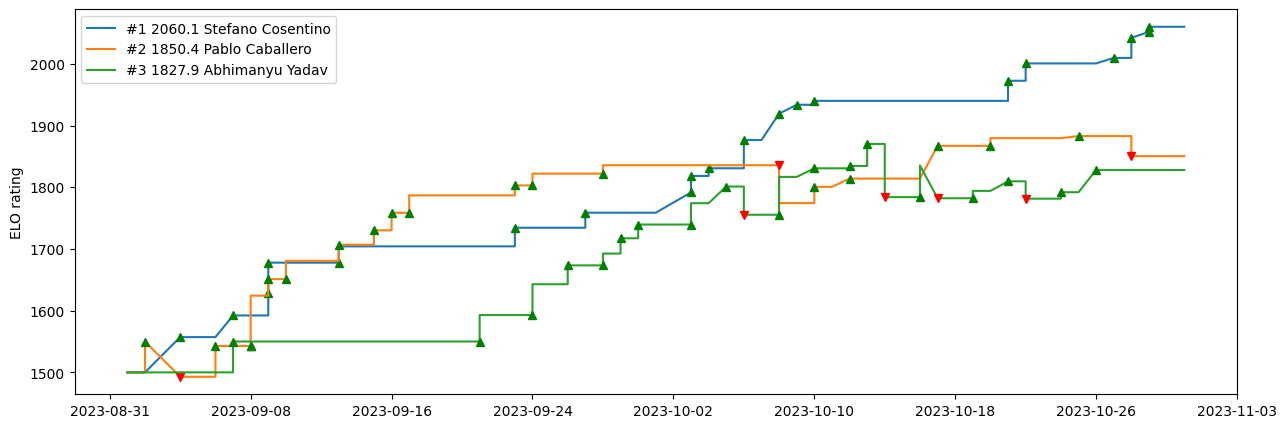

In [52]:
CE = ComputeElo()
CE.add_players(df_player['name'], rating=1500)

# Iterate through all records and update elo's
for idx, row in df.sort_values('ts').iterrows():
    CE.log_result(winner=row[f'player_{row["winner"]}'],
                  loser=row[f'player_{row["loser"]}'])

# Print ranks
rankings = CE.top(N=10, verbose=True)

# Plot progression
dfh = CE.generate_history()
f, ax = plt.subplots(1, 1, figsize=(15,5))
time_label = 'date'
for pos, (name, elo) in enumerate(CE.top(3), 1):
    ax.plot(df[time_label], dfh[name], '-', label=f"#{pos} {elo:.1f} {name[:17]}")
    for idx, row in df.iterrows():
        if name!=row['player_a'] and name!=row['player_b']:
            continue
        sym = '^g' if row["winner_name"]==name else 'vr'
        plt.plot(row[time_label], dfh[name].iloc[idx], sym)
ax.xaxis.set_major_locator(plt.MaxNLocator(10)); ax.set_ylabel('ELO rating'); ax.legend();

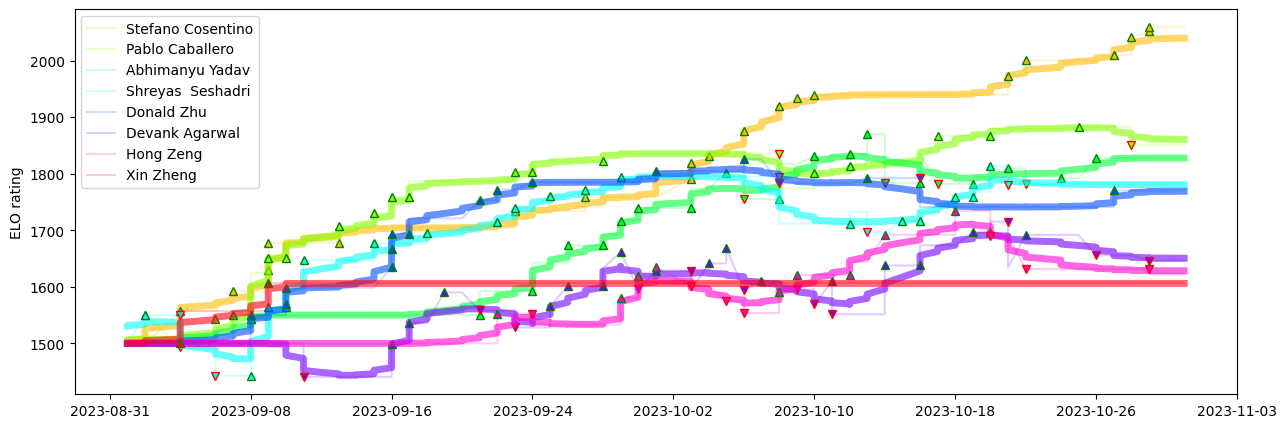

In [53]:
import matplotlib as mpl
from scipy.ndimage import gaussian_filter1d
cmap = mpl.cm.get_cmap('hsv')

f, ax = plt.subplots(1, 1, figsize=(15,5))
time_label = 'date'
for k, name in enumerate([name for name, _ in CE.top(8)], 1):
    ax.plot(df[time_label], dfh[name], '-', color=cmap(k/8), label=name[:17], alpha=.2);
    ax.plot(df[time_label], gaussian_filter1d(dfh[name], sigma=4), '-', color=cmap(k/8), lw=5, alpha=.6);
    for idx, row in df.iterrows():
        if name!=row['player_a'] and name!=row['player_b']:
            continue
        sym = '^g' if row["winner_name"]==name else 'vr'
        plt.plot(row[time_label], dfh[name].iloc[idx], sym, markerfacecolor=cmap(k/8))
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.set_ylabel('ELO rating'); ax.legend();

In [32]:
df_player

,name,link,player_id
0,Shreyas Seshadri,/Public/PlayerMatches/?teamId=144264139,144264139
1,Abhimanyu Yadav,/Public/PlayerMatches/?teamId=144264147,144264147
2,Pablo Caballero,/Public/PlayerMatches/?teamId=144367225,144367225
3,Devank Agarwal,/Public/PlayerMatches/?teamId=144569465,144569465
4,Stefano Cosentino,/Public/PlayerMatches/?teamId=144232167,144232167
...,...,...,...
84,Brian Chin,/Public/PlayerMatches/?teamId=144367238,144367238
85,Silva Oliveros,/Public/PlayerMatches/?teamId=143910773,143910773
86,Zeal Bhatt,/Public/PlayerMatches/?teamId=144347221,144347221
87,Tina Ye,/Public/PlayerMatches/?teamId=144232162,144232162


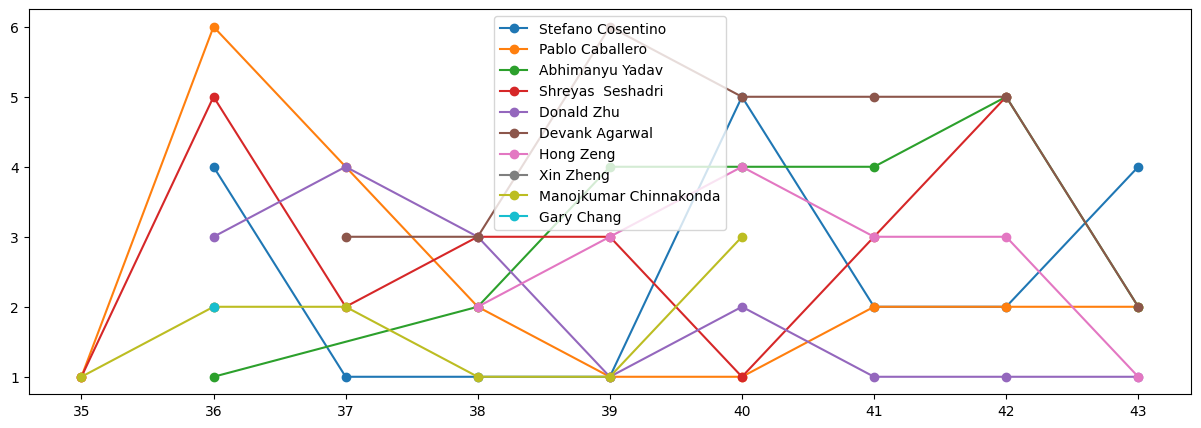

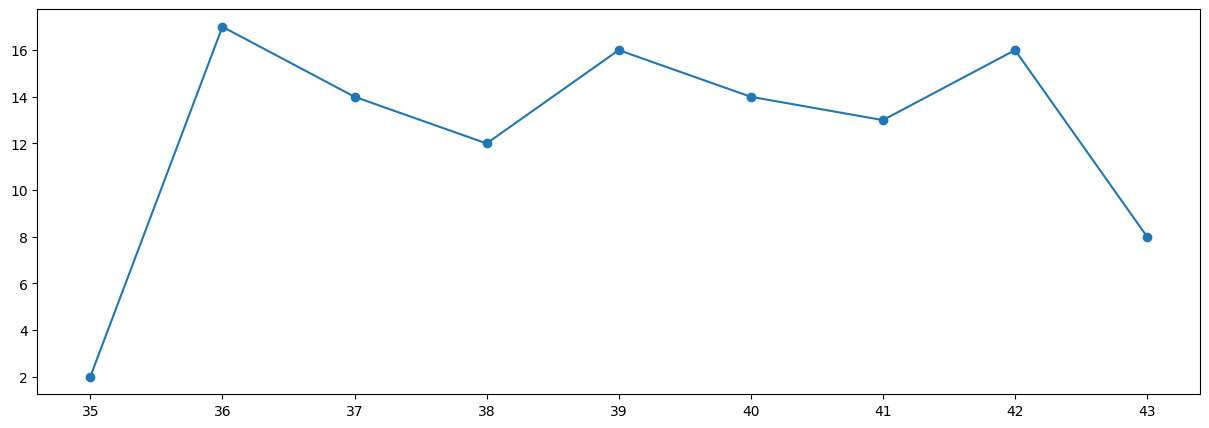

In [54]:
f, ax = plt.subplots(1, 1, figsize=(15,5))
for k, (player, _) in enumerate(CE.top(10), 1):
    df_ = df[(df['player_a']==player) | (df['player_b']==player)].groupby('week_nr').count()
    ax.plot(df_['player_a'], '-o', label=player);
ax.legend();

f, ax = plt.subplots(1, 1, figsize=(15,5))
top10 = set([player for player,_ in CE.top(6)])
df_ = df[(df['player_a'].isin(top10)) | (df['player_b'].isin(top10))].groupby('week_nr').count()
ax.plot(df_['player_a'], '-o');

In [14]:
[name for name, _ in CE.top(10)]